In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import pickle
from random import shuffle
import random
random.seed=41

# Load files

In [2]:
# load annotated_files
with open('./annotated_files.json', 'r') as f:
    files = json.load(f)

file_names = [file["data"]["file_name"] for file in files]
pdf_folder = os.listdir("./pdfs")

"""
  To show that what files from annotated_files
  aren't existing in pdf_folder
"""

wrong_files = []
# for name in file_names:
#   if name not in pdf_folder:
#     wrong_files.append(name)
# wrong_files.append("4470.pdf")
# print(wrong_files)

# get domain list

domain_list = []
for file in files:
    domain_list.append(file["data"]["domain"])

domain_list = [element for element in set(domain_list)]
print(domain_list)

['bank', 'law', 'finance', 'fpt', 'qms']


# Mapping
LabelStudio format to DocLayNet format

In [3]:
convert_label_name = {
    "text": "Text",
    "title": "Section-header",
    "list-item": "List-item",
    "table": "Table",
    "figure": "Picture",
    "form": "Form",
    "footnote": "Footnote",
    "useless": "Useless"
}

# categories
count = -1
categories = []
for key in convert_label_name:
    count += 1
    category = {}
    category["id"] = count; category["name"] = key
                                              #convert_label_name[key]
    categories.append(category)

map_category_to_id = {item["name"]: item["id"] for item in categories}

# write into json file
def write_info_to_json(files, page_names, start_id):
    label_counts = {l:0 for l in convert_label_name.keys()}
    json_file = {
        "images": [],
        "annotations": [],
        "categories": categories
    }
    page_id = start_id
    annot_id = start_id
    for file in files:
        page_shape = {}
        for page in file["annotations"][0]["result"]:
          page_shape[page["to_name"]] = (page["original_height"], page["original_width"]) #(height, width)

        for page_dict in file["data"]["document"]:
            page_url = page_dict["page"]
            if page_url not in page_names:
              continue
            page_info = {}
            file_page = page_url[page_url.find("page_"): page_url.find(".")] # ex: page_0
            page_name = page_url.replace("/data/local-files/?d=documents/", "")
                                        # /data/local-files/?d=documents/
            page_name = page_name.replace(".jpg", "").replace(".png", "") + ".png"
            # page info
            page_info["id"] = page_id
            page_info["file_name"] = page_name

            if file_page in page_shape:
              page_info["height"] = page_shape[file_page][0]
              page_info["width"] = page_shape[file_page][1]
              json_file["images"].append(page_info)
            elif os.path.exists(os.path.join("./DocLayNet_9k/PNG", page_name)):
              img_shape = cv2.imread(os.path.join("./DocLayNet_9k/PNG", \
                                                  page_name)).shape # (height, width, channel)
              page_info["height"] = img_shape[0]
              page_info["width"] = img_shape[1]
              json_file["images"].append(page_info)

            for id, annotation in enumerate(file["annotations"][0]["result"]):
                if annotation["to_name"] == file_page:
                  img_shape = None


                  if os.path.exists(os.path.join("./DocLayNet_9k/PNG", page_name)):
                    img_shape = cv2.imread(os.path.join("./DocLayNet_9k/PNG", \
                                                        page_name)).shape # (height, width, channel)
                  annot = {}
                  try:
                    x_min = annotation["value"]["x"]*img_shape[1]/100
                    y_min = annotation["value"]["y"]*img_shape[0]/100
                    width = annotation["value"]["width"]*img_shape[1]/100
                    height = annotation["value"]["height"]*img_shape[0]/100

                    bbox = [x_min, y_min, width, height]
                    annot["bbox"] = bbox
                    annot["bbox_mode"] = 1

                    if "rectanglelabels" in annotation["value"]:
                        old_label = annotation["value"]["rectanglelabels"][0]
                    else:
                        print(annotation)
                        continue
                    annot["category_id"] = map_category_to_id[old_label.strip()]
                    label_counts[old_label.strip()]+=1
                                          # map_category_to_id[convert_label_name[old_label.strip()]]
                    annot["image_id"] = page_id
                    annot["id"] = annot_id
                    annot["iscrowd"] = 0
                    annot["area"] = width * height

                    json_file["annotations"].append(annot)
                    annot_id += 1
                  except:
                     print('annot incorrect,',page_name)
            page_id += 1

    return json_file, label_counts

In [4]:

# write into json file
def label_count(files, page_names):
    label_counts = {l:0 for l in convert_label_name.keys()}
    json_file = {
        "images": [],
        "annotations": [],
        "categories": categories
    }
    page_id = 0
    annot_id = 0
    for file in files:
        page_shape = {}
        for page in file["annotations"][0]["result"]:
          page_shape[page["to_name"]] = (page["original_height"], page["original_width"]) #(height, width)

        for page_dict in file["data"]["document"]:
            page_url = page_dict["page"]
            if page_url not in page_names:
              continue
            page_info = {}
            file_page = page_url[page_url.find("page_"): page_url.find(".")] # ex: page_0
            page_name = page_url.replace("/data/local-files/?d=documents/", "")
                                        # /data/local-files/?d=documents/
            page_name = page_name.replace(".jpg", "").replace(".png", "") + ".png"
            # page info
            page_info["id"] = page_id
            page_info["file_name"] = page_name

            if file_page in page_shape:
              page_info["height"] = page_shape[file_page][0]
              page_info["width"] = page_shape[file_page][1]
              json_file["images"].append(page_info)
            elif os.path.exists(os.path.join("./DocLayNet_9k/PNG", page_name)):
              img_shape = cv2.imread(os.path.join("./DocLayNet_9k/PNG", \
                                                  page_name)).shape # (height, width, channel)
              page_info["height"] = img_shape[0]
              page_info["width"] = img_shape[1]
              json_file["images"].append(page_info)

            for id, annotation in enumerate(file["annotations"][0]["result"]):
                if annotation["to_name"] == file_page:
                  img_shape = None


                  if os.path.exists(os.path.join("./DocLayNet_9k/PNG", page_name)):
                    img_shape = cv2.imread(os.path.join("./DocLayNet_9k/PNG", \
                                                        page_name)).shape # (height, width, channel)
                  else:
                    print(f'{page_name} not found')
                  annot = {}
                  try:
                    x_min = annotation["value"]["x"]*img_shape[1]/100
                    y_min = annotation["value"]["y"]*img_shape[0]/100
                    width = annotation["value"]["width"]*img_shape[1]/100
                    height = annotation["value"]["height"]*img_shape[0]/100

                    bbox = [x_min, y_min, width, height]
                    annot["bbox"] = bbox
                    annot["bbox_mode"] = 1

                    if "rectanglelabels" in annotation["value"]:
                        old_label = annotation["value"]["rectanglelabels"][0]
                    else:
                        print(annotation)
                        continue
                    annot["category_id"] = map_category_to_id[old_label.strip()]
                    label_counts[old_label.strip()]+=1
                                          # map_category_to_id[convert_label_name[old_label.strip()]]
                    annot["image_id"] = page_id
                    annot["id"] = annot_id
                    annot["iscrowd"] = 0
                    annot["area"] = width * height

                    json_file["annotations"].append(annot)
                    annot_id += 1
                  except:
                    print(annotation)
            page_id += 1

    return json_file, label_counts

In [5]:
# split files into each domains

domain_dict = {domain: [] for domain in domain_list}
annotated_files = []
domain_page = {domain: [] for domain in domain_list}
for annotated_file in files:
    if annotated_file["data"]["file_name"] not in wrong_files:
        domain = annotated_file['data']['domain']
        domain_dict[domain].append(annotated_file)
        annotated_files.append(annotated_file["data"]["file_name"])
        domain_page[domain].extend([page['page'] for page in annotated_file['data']['document']])
    else:
        print(annotated_file["data"]["file_name"].strip(".pdf"))

# Split files

In [6]:

def train_test_split(train_ratio = 0.8, val_ratio=0.1):
    
    train_annotated_pages = []
    val_annotated_pages = []
    test_annotated_files = []
    with open('./DocLayNet_9k/COCO/test copy.json') as f:
        test = json.load(f)
    # with open('./DocLayNet_9k/COCO/val.json') as f:
    #     dev= json.load(f)
    # test['images']+=dev['images']
    # test['annotations']+=dev['annotations']
    test_imgs = [t['file_name'] for t in test['images']]
    test_by_domain = {}
    page = {d:{
                'train': 0,
                'val': 0,
                'test': 0,
            } for d in domain_list}
    for domain in domain_list:
        shuffle(domain_page[domain])
        num_train_samples = int(len(domain_page[domain]) * train_ratio)
        num_val_samples = int(len(domain_page[domain]) * val_ratio)
        page[domain]['train']=num_train_samples
        page[domain]['val']=num_val_samples
        page[domain]['test']=int(len(domain_page[domain]))-num_train_samples-num_val_samples
        train_annotated_pages.extend(domain_page[domain][:num_train_samples])
        val_annotated_pages.extend(domain_page[domain][num_train_samples:num_val_samples+num_train_samples])
        test_annotated_files.extend(domain_page[domain][num_val_samples+num_train_samples:])
        test_by_domain[domain] = {'samples': [sample for sample in domain_page[domain] if sample.split('/')[-1].replace('.jpg','.png') in test_imgs]}
    print(page)
    # shuffle(train_annotated_files) # shuffle data
    # shuffle(test_annotated_files)

    return train_annotated_pages, val_annotated_pages, test_annotated_files, test_by_domain

train_annotated_pages, val_annotated_pages, test_annotated_files, test_by_domain = train_test_split()

{'bank': {'train': 165, 'val': 20, 'test': 22}, 'law': {'train': 4633, 'val': 579, 'test': 580}, 'finance': {'train': 1279, 'val': 159, 'test': 161}, 'fpt': {'train': 111, 'val': 13, 'test': 15}, 'qms': {'train': 1177, 'val': 147, 'test': 148}}


In [7]:
test_by_domain

{'bank': {'samples': ['/data/local-files/?d=documents/BIEUPHIDICHVUTHECAPNHAT18821_page_4.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_38.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_58.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_16.jpg',
   '/data/local-files/?d=documents/15057_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_5_NAM_2022_page_4.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_71.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_0.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_92.jpg',
   '/data/local-files/?d=documents/7968_CV_TRIEN_KHAI_NANG_CAP_SMB_LAN_3__final_1_page_1.jpg',
   '/data/local-files/?d=documents/1_FAQ_phien_ban_cho_khach_hang_page_21.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_47.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_57.jpg',
   '/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_

# Analyze pages/each domain in train/val:

In [8]:
len(train_annotated_pages),len(val_annotated_pages), len(test_annotated_files)

(7365, 918, 926)

In [9]:
# len(train_annotated_file)/len(annotated_file)

# train_data, train_label_counts = write_info_to_json(files=files,page_names = train_annotated_pages,start_id=0)
# val_data, val_label_counts = write_info_to_json(files=files,page_names = val_annotated_pages,start_id=10000)
# test_data, test_label_counts = write_info_to_json(files=files,page_names = test_annotated_files,start_id=20000)

for domain in test_by_domain.keys():
    
    test_by_domain[domain]['data'], test_by_domain[domain]['counts'] = write_info_to_json(files=files,page_names = test_by_domain[domain]['samples'],start_id=30000)


In [10]:

list_png = os.listdir("./DocLayNet_9k/PNG/")

def object(data):
    object = {key: [] for key in data}
    ids = []

    for image in data["images"]:
        if image["file_name"] != "11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022_page_3.png":
          object["images"].append(image)
          ids.append(image["id"])

    for annot in data["annotations"]:
        if annot["image_id"] in ids:
            object["annotations"].append(annot)
    object["categories"] = data["categories"]

    for id, image in enumerate(data["images"]):
      if "11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022" in image["file_name"]:
          image_shape = cv2.imread("./DocLayNet_9k/PNG/" + image["file_name"]).shape
          object["images"][id]["height"] = image_shape[0]
          object["images"][id]["width"] = image_shape[1]

    return object

# train_data = object(train_data)
# val_data = object(val_data)
# test_data = object(test_data)

# train_object = json.dumps(train_data)
# val_object = json.dumps(val_data)
# test_object = json.dumps(test_data)
# with open("./DocLayNet_9k/COCO/train.json", "w") as file:
#     file.write(train_object)

# with open("./DocLayNet_9k/COCO/val.json", "w") as file:
#     file.write(val_object)
# with open("./DocLayNet_9k/COCO/test.json", "w") as file:
#     file.write(test_object)

In [11]:
for domain in test_by_domain.keys():
    test_object=json.dumps(object(test_by_domain[domain]['data']))
    with open(f"./DocLayNet_9k/COCO/test_{domain}.json", "w") as file:
        file.write(test_object)

# Test

In [12]:
%cd ./DocLayNet_9k

train = json.load(open("COCO/train.json"))
val = json.load(open("COCO/val.json"))

train_names = [image["file_name"] for image in train["images"]]
val_names = [image["file_name"] for image in val["images"]]

print("Num pages: ", len(train["images"]) + len(val["images"]))
print("All pages: ", len(os.listdir("PNG")))

/home/vinhvq11/Desktop/PDF_extraction/fine_tuning_vgt/data_loader/DocLayNet_9k
Num pages:  8283
All pages:  9209


In [13]:
train["categories"]

[{'id': 0, 'name': 'text'},
 {'id': 1, 'name': 'title'},
 {'id': 2, 'name': 'list-item'},
 {'id': 3, 'name': 'table'},
 {'id': 4, 'name': 'figure'},
 {'id': 5, 'name': 'form'},
 {'id': 6, 'name': 'footnote'},
 {'id': 7, 'name': 'useless'}]

In [14]:
annots = train["annotations"]
print(annots[0])
categories = list(set([category["id"] for category in train["categories"]]))
print(categories)

for annot in annots:
  if int(annot["category_id"]) not in categories:
    print(annot)

{'bbox': [77.63257279460453, 139.88210518543272, 443.1384142933533, 36.67666998041378], 'bbox_mode': 1, 'category_id': 1, 'image_id': 0, 'id': 0, 'iscrowd': 0, 'area': 16252.841376681195}
[0, 1, 2, 3, 4, 5, 6, 7]


In [15]:
import pandas as pd

dict = {"name": sorted(train_names + val_names), "grid": sorted(os.listdir("VGT_DocLayNet_grid_pkl"))}
pd.DataFrame(dict)

ValueError: All arrays must be of the same length

# Visualize

### Visualize image with boxes

In [ ]:
def show_image_with_bbox(image_id):
  image = train["images"][image_id]
  annots_for_image = []

  for annot in train["annotations"]:
    if annot["image_id"] == image["id"]:
      annots_for_image.append(annot)

  image = cv2.imread(os.path.join("./PNG", image["file_name"]))
  image_size = image.shape # height, width, channel

  for annot in annots_for_image:
    box = annot["bbox"]
    image = cv2.rectangle(image,
                          (int(box[0]), int(box[1])),
                          (int((box[0] + box[2])), int((box[1] + box[3]))),
                          color = (255, 0, 0),
                          thickness = 2)
  plt.imshow(image)

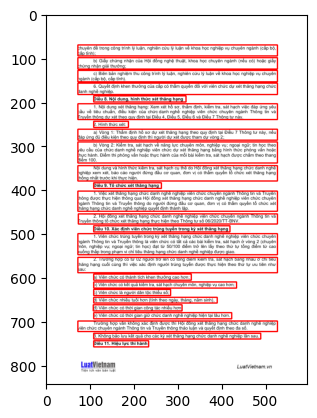

In [ ]:
show_image_with_bbox(2)

### Visualize image with grid

In [ ]:
def show_image_with_grid(image_id):
  image = train["images"][image_id]
  annots_for_image = []

  for annot in train["annotations"]:
    if annot["image_id"] == image["id"]:
      annots_for_image.append(annot)

  grid_image_path = os.path.join("./VGT_DocLayNet_grid_pkl",
                                  image["file_name"].replace(".png", ".pdf.pkl"))

  image_path = os.path.join("./PNG",
                            image["file_name"])

  image = cv2.imread(image_path)
  image_size = image.shape # height, width, channel

  with open(grid_image_path, "rb") as file:
    content = pickle.load(file)

  print(content.keys())

  for box in content["bbox_subword_list"]:
    image = cv2.rectangle(image,
                          (int(box[0]), int(box[1])),
                          (int((box[0] + box[2])), int((box[1] + box[3]))),
                          color = (255, 0, 0),
                          thickness = 2)
  plt.imshow(image)

dict_keys(['input_ids', 'bbox_subword_list', 'texts', 'bbox_texts_list'])


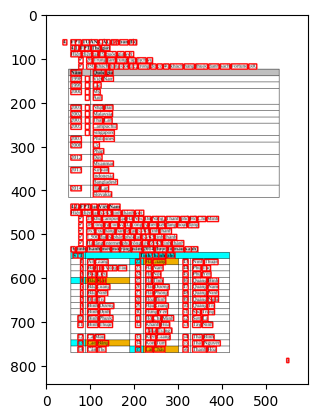

In [ ]:
show_image_with_grid(6)

# MakeGrid

In [ ]:
!pip install pdfplumber
!pip install transformers

%cd /content/drive/MyDrive/github/vision-grid-transformer/VGT/object_detection

!python create_grid_input.py \
--pdf ./DocLayNet_9k/pdfs \
--output ./DocLayNet_9k/VGT_DocLayNet_grid_pkl \
--tokenizer "FacebookAI/xlm-roberta-base" \
--model "doclaynet"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 856.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.4 MB/s eta 0:00:00
/content/drive/MyDrive/github/vision-grid-transformer/VGT/object_detection
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 99.5kB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
config.json: 100% 615/615 [00:00<00:00, 3.26MB/s]
sentencepiece.bpe.model: 100% 5.07M/5.07M [00:00<00:00, 28.4MB/s]
tokenizer.json: 100% 9.10M/9.10M [00:00<00:00, 31.8MB/s]
